# Predicting-Obesity-Rate-Based-on-Food-Environment

## 2. EDA and Modelling

## Contents

- [Imports](#Imports)
- [EDA](#EDA)
    - [Cleaning the Merged Dataset](#Cleaning-the-Merged-Dataset)
    - [Data Dictionary](#Data-Dictionary)
    - [Feature Collinearity](#Feature-Collinearity)
    - [Pairplot](#Pairplot)
- [Preprocessing](#Preprocessing)
    - [Train/Test Split and Scale](#Train/Test-Split-and-Scale)
- [Regression Metrics Function](#Regression-Metrics-Function)
- [Modelling](#Modelling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression with all features](#Linear-Regression-with-all-features)
    - [Random Forest for important features](#Random-Forest-for-important-features)
    - [Linear Regression with Random Forest important features](#Linear-Regression-with-Random-Forest-important-features)
    - [Linear Regression with correlated features](#Linear-Regression-with-correlated-features)
    - [Regularized Linear Regression](#Regularized-Linear-Regression)
        - [Lasso](#Lasso)
        - [Ridge](#Ridge)
    - [Random Forest](#Random-Forest)
    - [Adaboost on Random Forest](#Adaboost-on-Random-Forest)
    - [Decision Tree Regressor](#Decision-Tree-Regressor)
- [Predictions](#Predictions)
    - [Table of results](#Table-of-results)
- [Conclusions and Limitations](#Conclusions-and-Limitations)

## Imports 

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

[Data Dictionary ](https://www.ers.usda.gov/webdocs/DataFiles/80526/archived_documentation_August2015.pdf?v=0)

# EDA

# Cleaning the Merged Dataset

We removed any columns that included the year past 2013 since the target for this analysis is 2013. We also cleaned up the names of the columns

In [2]:
df = pd.read_csv('../Data/df.csv')

In [3]:
df.columns

Index(['FIPS', 'FIPS.1', 'State', 'County', 'PCT_DIABETES_ADULTS08',
       'PCT_DIABETES_ADULTS13', 'PCT_OBESE_ADULTS08', 'PCT_OBESE_ADULTS13',
       'RECFAC09', 'RECFAC14', 'LACCESS_POP10', 'LACCESS_POP15',
       'PCH_LACCESS_POP_10_15', 'PCT_LACCESS_POP10', 'PCT_LACCESS_POP15',
       'LACCESS_LOWI10', 'LACCESS_LOWI15', 'PCH_LACCESS_LOWI_10_15',
       'PCT_LACCESS_LOWI10', 'PCT_LACCESS_LOWI15', 'LACCESS_HHNV10',
       'LACCESS_HHNV15', 'PCH_LACCESS_HHNV_10_15', 'PCT_LACCESS_HHNV10',
       'PCT_LACCESS_HHNV15', 'LACCESS_SNAP15', 'PCT_LACCESS_SNAP15',
       'LACCESS_CHILD10', 'LACCESS_CHILD15', 'LACCESS_CHILD_10_15',
       'PCT_LACCESS_CHILD10', 'PCT_LACCESS_CHILD15', 'LACCESS_SENIORS10',
       'LACCESS_SENIORS15', 'PCH_LACCESS_SENIORS_10_15',
       'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_SENIORS15', 'LACCESS_WHITE15',
       'PCT_LACCESS_WHITE15', 'LACCESS_BLACK15', 'PCT_LACCESS_BLACK15',
       'LACCESS_HISP15', 'PCT_LACCESS_HISP15', 'LACCESS_NHASIAN15',
       'PCT_LACCESS_N

In [4]:
#predicting the 13 obesity rate, drop year after
col_list = [col for col in df.columns if '15' in col]
df.drop(col_list, axis=1, inplace=True)

In [5]:
#dropping 2014 data
col_list_2 = [col for col in df.columns if '14' in col]
df.drop(col_list_2, axis=1, inplace=True)

In [6]:
#dropping 2013 data
col_list_3 = [col for col in df.columns if '16' in col]
df.drop(col_list_3, axis=1, inplace=True)

In [7]:
#dropping redundant data 
#col_list_4 = [col for col in df.columns if '7' in col]
#df.drop(col_list_4, axis=1, inplace=True)

#### Data Dictionary

We are going to rename the final features included in the model. Since the names given are not clear. We also dropped FIPS.1.

In [8]:
df.drop(columns = ['FIPS.1'], inplace=True)

Data Dictionary of the Final merged data fram

| Name                  | Description                                      |
|-----------------------|--------------------------------------------------|
| PCT_DIABETS_ADULTS08  | Adult diabetes rate in 2008                      |
| PCT_DIABETES_ADULTS13 | Adult Diabetes rate in 2013                      |
| RECFAC09              | Number of fitness facilities                     |
| GROC09                | Count of grocery stores                          |
| SUPERC                | Number of superstores                            |
| SNAPS12               | SNAP-Authorized stores                           |
| WICS12                | WIC-authorized stores                            |
| LACCESS_POP10         | Count of population- low access to store         |
| PCT_LACCESS_POP10     | Percent of population - low access to store      |
| LACCESS_LOWI10        | Low income and low access to store, 2010         |
| PCT_LACCESS_LOWI10    | Percent Low income and low access to store, 2010 |
| LACCESS_HHNV10        | Households, no car & low access to store, 2010   |
| PCT_LACCESS_HHNV10    | Percent of households no car and low access      |
| LACCESS_CHILD10       | Child Low Access to Car                          |
| SNAPSPTH12            | SNAP-authorized stores/1,000 pop                 |
| GHVEG_FARMS07         | Greenhouse vegetable and fresh herb farms        |
| FMRKT09               | Number of Farmer's Markets                       |
| SPECS09               | Number of Specialty Stores                       |
| CONVS09               | Number of Convenience Stores                     |
| PCT_LOCLFARM07        | Farms with direct sales                          |
|                       |                                                  |

We looked at count of grocery stores and convenience stores to see if there is a correlation with the states with the highest number of stores and the state with the lowest obesity rates.

In [9]:
group_df_conv = df.groupby('State')[['CONVS09']].agg(lambda x:x.value_counts().index[0])
group_df_groc = df.groupby('State')[['GROC09']].agg(lambda x:x.value_counts().index[0])
group_df_rec = df.groupby('State')[['RECFAC09']].agg(lambda x:x.value_counts().index[0])
group_df_obesity = df.groupby('State')[['PCT_OBESE_ADULTS13']].agg(lambda x:x.mean())

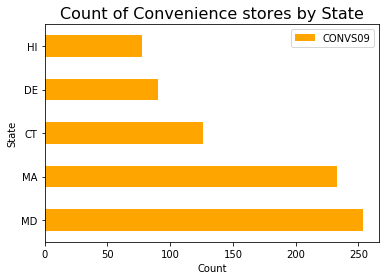

In [10]:
group_df_conv.sort_values(by='CONVS09', ascending=False).head().plot(kind='barh', color='orange')
plt.xlabel('Count') 
plt.ylabel('State')
plt.title('Count of Convenience stores by State', fontsize = 16);

Massachusetts is again among the state with the highest number of convenience stores. 

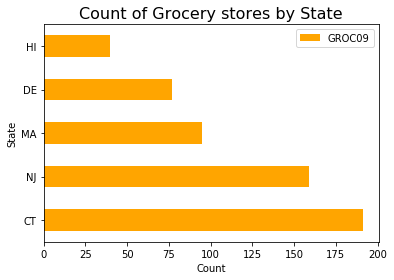

In [11]:
group_df_groc.sort_values(by='GROC09', ascending=False).head().plot(kind='barh', color='orange')
plt.xlabel('Count')
plt.ylabel('State')
plt.title('Count of Grocery stores by State', fontsize = 16);

Connecticut, NJ, Massachusets, Delaware and Hawaii have the highest number of stores. 

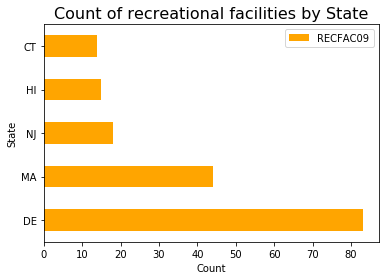

In [12]:
group_df_rec.sort_values(by='RECFAC09', ascending=False).head().plot(kind='barh', color='orange')
plt.xlabel('Count')
plt.ylabel('State')
plt.title('Count of recreational facilities by State', fontsize = 16);

Delaware has the highest number of recreational facilities however not in the top five of states with the lowest obesity rate.

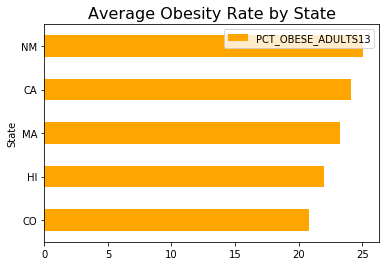

In [13]:
group_df_obesity.sort_values(by='PCT_OBESE_ADULTS13', ascending=True).head().plot(kind='barh', color='orange')
plt.xlabel='Count' 
plt.ylabel='State'
plt.title('Average Obesity Rate by State', fontsize = 16);

Massuchestts has the highest number of stores and the lowest average obesity rates

### Feature Collinearity

- Which features should be included in the model?
- Feature multicollinearity

First we checked collinearity among the different feature and the percent of obese adults in 2013. We then found the features with collinearity greater than .1 and ran the model with those features. We tried a variety of thresholds.

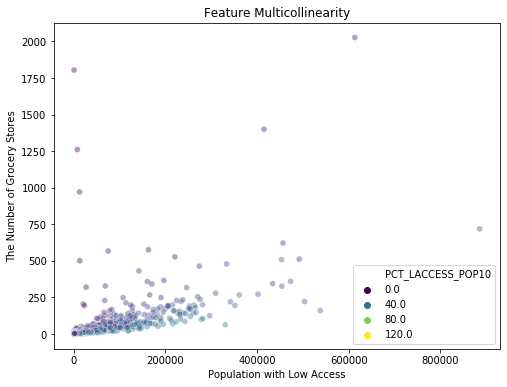

In [14]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['LACCESS_POP10'], y=df['GROC09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis')
plt.title("Feature Multicollinearity")
ax.set(xlabel = "Population with Low Access", ylabel = "The Number of Grocery Stores");

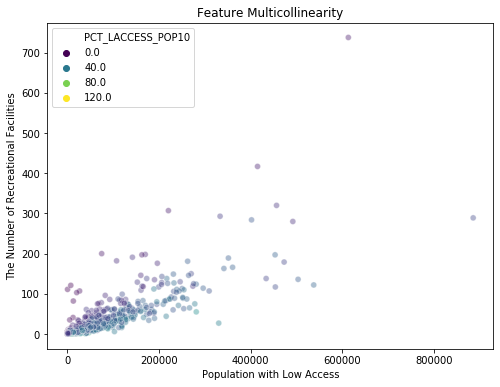

In [15]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['LACCESS_POP10'], y=df['RECFAC09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis')
plt.title("Feature Multicollinearity")
ax.set(xlabel = "Population with Low Access", ylabel = "The Number of Recreational Facilities");

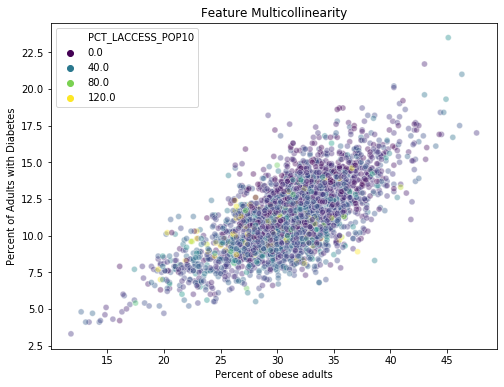

In [16]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['PCT_OBESE_ADULTS13'], y=df['PCT_DIABETES_ADULTS13'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');

plt.title("Feature Multicollinearity");
ax.set(xlabel = "Percent of obese adults", ylabel = "Percent of Adults with Diabetes");

Not suprising that the diabetes rate for adults is very correlated with obesity rates. 

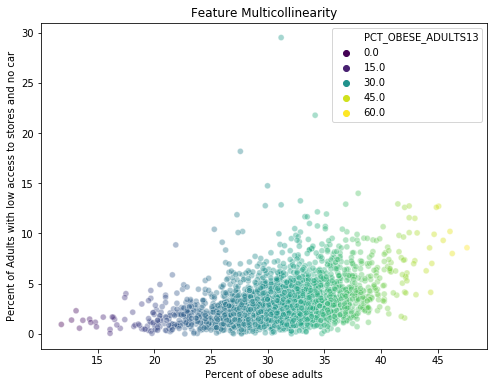

In [17]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['PCT_OBESE_ADULTS13'], y=df['PCT_LACCESS_HHNV10'], hue=df['PCT_OBESE_ADULTS13'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');
plt.title("Feature Multicollinearity");
ax.set(xlabel = "Percent of obese adults", ylabel = "Percent of Adults with low access to stores and no car");

There isn't a strong coorelation between grocery stores and obestiy rates. 

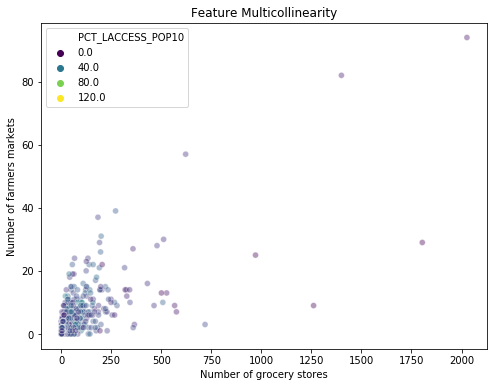

In [18]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['GROC09'], y=df['FMRKT09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');


plt.title("Feature Multicollinearity");
ax.set(xlabel = "Number of grocery stores", ylabel = "Number of farmers markets");

There are a few outliers that have a lot of grocery stores and farmers market. The outliers are Connecticut, Massachusetts and Delaware.

In [19]:
correlation = df.corr()[['PCT_OBESE_ADULTS13']].head(10)
sorted_coefs = abs(correlation).sort_values('PCT_OBESE_ADULTS13', ascending = False)
    
strong_corr = sorted_coefs[(sorted_coefs['PCT_OBESE_ADULTS13'] > .1)]

In [20]:
height = list(strong_corr['PCT_OBESE_ADULTS13'])

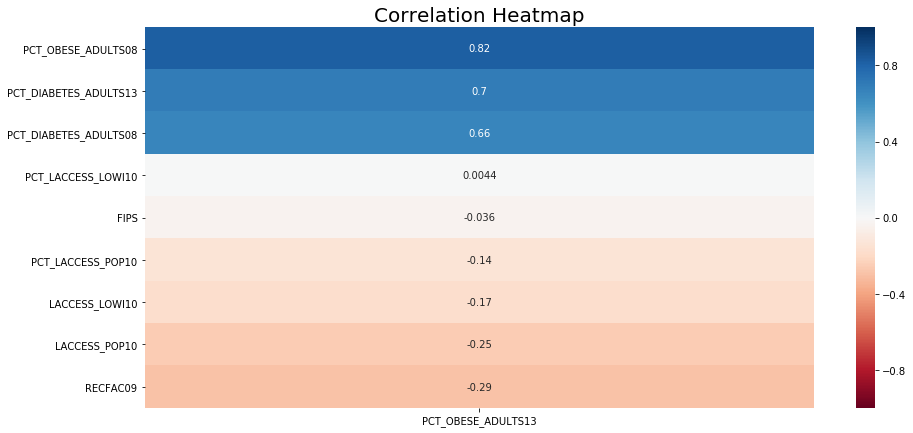

In [21]:
fig, ax = plt.subplots(figsize=(15,7)) 
sns.heatmap(df.corr()[['PCT_OBESE_ADULTS13']].head(10).sort_values('PCT_OBESE_ADULTS13', ascending=False).iloc[1:],
            annot=True, vmin=-1, vmax=1, cmap="RdBu")
plt.title('Correlation Heatmap', fontsize = 20);

RECFAC- is the number of Recreation & fitness facilities, 2009 and percent of adults with diabetes have a strong correlation to percent of obese adults.

<BarContainer object of 8 artists>

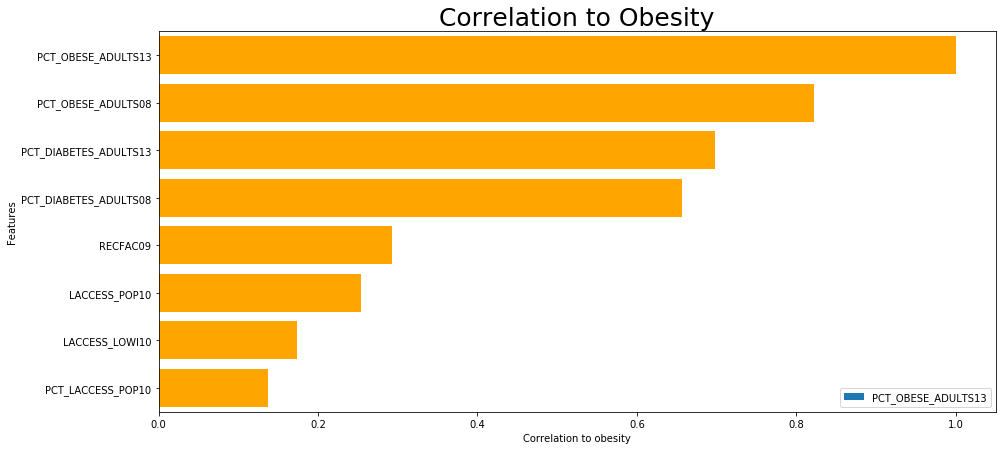

In [22]:
ax = strong_corr.head(15).plot(kind='barh', figsize = (15,7))
ax.set(ylabel='Features', xlabel='Correlation to obesity') 
ax.invert_yaxis()
plt.title('Correlation to Obesity', fontsize = 25)
plt.barh(strong_corr.head(15).index, height, color='orange')

Low access and low income also highley correlated to obesity.

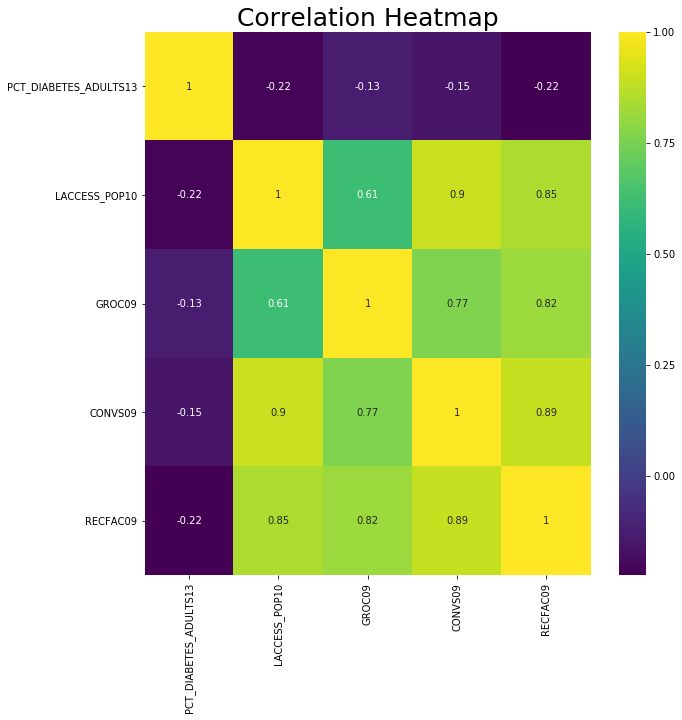

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(df[[
    'PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]\
.corr(),
            annot=True, cmap="RdBu")
ax.set_ylim(len(df[[
    'PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]\
.corr())-1, -1)
plt.title('Correlation Heatmap', fontsize = 25);

There is a high correlation between low access and recreation facilities as well as low access and number of convenience stores. Before, running the model we should remove one the features. 

In [24]:
# check for correlation 
corr = df.corr()
corr['PCT_OBESE_ADULTS13'].sort_values(ascending=False).head(10)

PCT_OBESE_ADULTS13       1.000000
PCT_OBESE_ADULTS08       0.821918
PCT_DIABETES_ADULTS13    0.698009
PCT_DIABETES_ADULTS08    0.656896
PCT_LACCESS_HHNV10       0.402890
SNAPSPTH12               0.345473
CONVSPTH09               0.174131
SUPERCPTH09              0.089896
WICSPTH08                0.062218
WICSPTH12                0.044092
Name: PCT_OBESE_ADULTS13, dtype: float64

the access to stores - number of stores within 10 miles
conv - convenience stores
supermarkets 
spec - specialized stores 
Wics - Farmers markets 

### Pairplot 

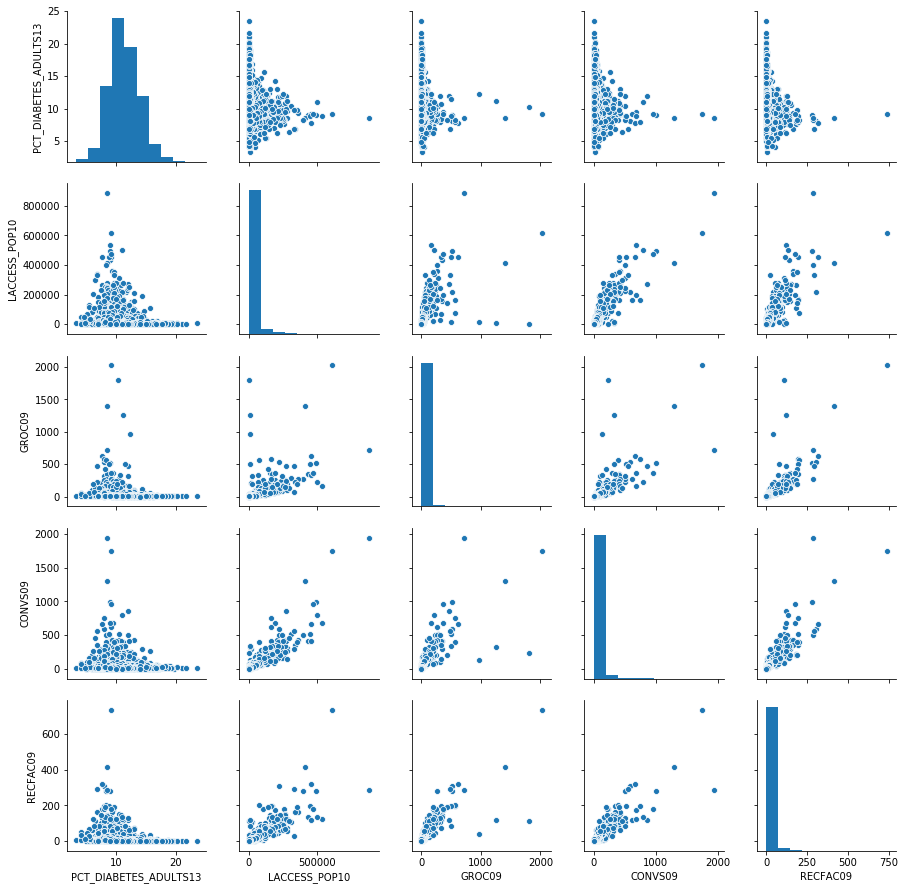

In [25]:
sns.pairplot(df[['PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]);

Total access to stores and number of recreational facilites are very correlated. Low access to stores and the number of grocery stores are very correlated. 

 Dummying the State and County columns before running the model.

In [26]:
df.drop(columns = ['FIPS'], inplace= True)

In [27]:
# checking all variable types are numeric
df.dtypes

State                     object
County                    object
PCT_DIABETES_ADULTS08    float64
PCT_DIABETES_ADULTS13    float64
PCT_OBESE_ADULTS08       float64
PCT_OBESE_ADULTS13       float64
RECFAC09                   int64
LACCESS_POP10            float64
PCT_LACCESS_POP10        float64
LACCESS_LOWI10           float64
PCT_LACCESS_LOWI10       float64
LACCESS_HHNV10           float64
PCT_LACCESS_HHNV10       float64
LACCESS_CHILD10          float64
PCT_LACCESS_CHILD10      float64
LACCESS_SENIORS10        float64
PCT_LACCESS_SENIORS10    float64
GROC09                     int64
GROCPTH09                float64
SUPERC09                   int64
SUPERCPTH09              float64
CONVS09                    int64
CONVSPTH09               float64
SPECS09                    int64
SPECSPTH09               float64
SNAPS12                  float64
SNAPSPTH12               float64
WICS08                     int64
WICS12                     int64
PCH_WICS_08_12           float64
WICSPTH08 

In [28]:
# the two object types
list_of_cols_to_dummy = ['State', 'County']

In [29]:
df = pd.get_dummies(df, columns = list_of_cols_to_dummy, drop_first = True)

### Regression Metrics Function

In [30]:
# a function to calculate the RMSE for all the models I run 
def regression_metrics(y,preds):
    sq_diff = (y-preds)**2 
    MSE = metrics.mean_squared_error(y,preds)
    RMSE = np.sqrt(MSE)
    print(f'This is MSE: {MSE}')
    print(f'This is RMSE: {RMSE}')

## Preprocessing

## Train/Test Split and Scale

In [31]:
df.columns

Index(['PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13', 'PCT_OBESE_ADULTS08',
       'PCT_OBESE_ADULTS13', 'RECFAC09', 'LACCESS_POP10', 'PCT_LACCESS_POP10',
       'LACCESS_LOWI10', 'PCT_LACCESS_LOWI10', 'LACCESS_HHNV10',
       ...
       'County_Yellow Medicine', 'County_Yellowstone', 'County_Yoakum',
       'County_Yolo', 'County_York', 'County_Young', 'County_Yuba',
       'County_Yuma', 'County_Zapata', 'County_Zavala'],
      dtype='object', length=1814)

In [32]:
#first looking at all the features
#removed convs09 since really correlated variables
X = df.drop(columns = ['PCT_OBESE_ADULTS13', 'CONVS09','PCT_LACCESS_HHNV10','PCT_LACCESS_LOWI10', 'SNAPSPTH12'])

y = df['PCT_OBESE_ADULTS13']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .33,
                                                    random_state=22)

In [34]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# Modelling

## Baseline Model

The baseline is the mean so we compare all the models results to the RMSE of 4.52 and 4.46. There aren't any real outliers, all the values should be considered when evaluating the model. An MSE baseline makes the most sense for this analysis.

In [35]:
# baseline for a linear regression model

base_mean = DummyRegressor(strategy = 'mean')

base_mean.fit(X_train, y_train)

y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)


In [36]:
np.sqrt(mean_squared_error(y_train, y_hat_base_train))

4.520220516824114

In [37]:
np.sqrt(mean_squared_error(y_test, y_hat_base_test))

4.460824953114096

## Linear Regression with all features

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
lr.score(X_train, y_train)

0.9224979521807647

In [40]:
lr.score(X_test, y_test)

0.6411221923084469

In [41]:
predict_train = lr.predict(X_train)
predict_test = lr.predict(X_test)

In [42]:
regression_metrics(y_train,predict_train)

This is MSE: 1.5835523397040934
This is RMSE: 1.2583927605100458


In [43]:
regression_metrics(y_test,predict_test)

This is MSE: 7.103604591998342
This is RMSE: 2.665258822703405


A model including all the features is extremely overfit and does not perform well on the testing set. 

### Random Forest  for important features

The benefits of using Random Forest is that they generalize better and are more accurate. 
Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two 

In [44]:
#https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators = 100)
    
model.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [45]:
#want to create a datafeam of the best features 
model.feature_importances_

array([1.60723135e-02, 8.23084176e-02, 6.53783413e-01, ...,
       3.49389889e-07, 0.00000000e+00, 1.13531564e-06])

In [46]:
features = X_train.columns
#turning the features and score into a dataframe to then plot 
features_df = pd.DataFrame({'Features': features, 'Score': model.feature_importances_.round(4)})
features_df.sort_values('Score', inplace=True, ascending=False)

#just looking at the top 25 
top_25_rf = features_df['Features'].head(25)

features_df[3:15]

,Features,Score
33,PCT_LOCLFARM12,0.0145
16,CONVSPTH09,0.0128
32,PCT_LOCLFARM07,0.0110
13,GROCPTH09,0.0106
23,WICSPTH08,0.0104
25,PCH_WICSPTH_08_12,0.0102
11,PCT_LACCESS_SENIORS10,0.0093
24,WICSPTH12,0.0086
7,LACCESS_HHNV10,0.0074
15,SUPERCPTH09,0.0074


In [47]:
#turning them into a list to use in the linear regression model
features_RF = list(top_25_rf)

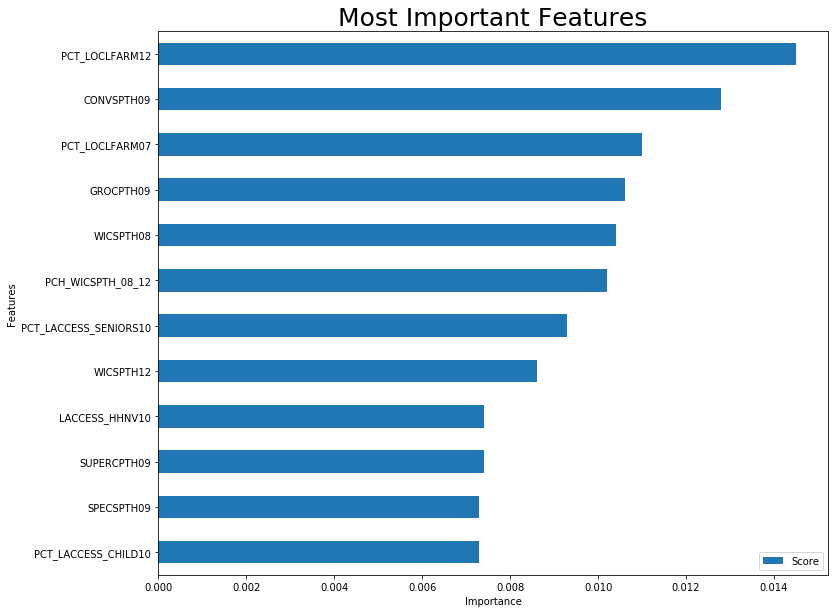

In [48]:
#plotting a bar graph of each feature and their score 
ax = features_df.set_index('Features')[3:15].sort_values(by = 'Score', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Importance', ylabel='Features') 
ax.invert_yaxis()
plt.title('Most Important Features', fontsize = 25);

The top features based on the importance score is the number of snap affiliated scores, the number of convenience stores, percent of the population with low access to stores and have no vehicles, number of grocery stores, the number of wics affiliated stores and the number of local farmers market. 

## Linear Regression with Random Forest important features

In [49]:
## Scalling of the Random Forest 
X_rf= df[features_RF]
y_rf = df['PCT_OBESE_ADULTS13']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, 
                             
                                                    random_state=42)

sc = StandardScaler()
Z_train_rf = sc.fit_transform(X_train_rf)
Z_test_rf = sc.transform(X_test_rf)

In [50]:
lr = LinearRegression()
lr.fit(Z_train_rf, y_train_rf)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
lr.score(Z_train_rf, y_train_rf)

0.7305573386309663

In [52]:
lr.score(Z_test_rf, y_test_rf)

0.7205551388002562

In [53]:
predict_train_rf = lr.predict(Z_train_rf)
predict_test_rf = lr.predict(Z_test_rf)

In [54]:
regression_metrics(y_train_rf,predict_train_rf)

This is MSE: 5.428411904785619
This is RMSE: 2.3298952561833373


In [55]:
regression_metrics(y_test_rf, predict_test_rf)

This is MSE: 5.727580777976751
This is RMSE: 2.393236465119306


In [56]:
lr.coef_

array([ 2.77640551,  1.50643576, -0.4602281 , -0.40624553, -0.1565757 ,
        0.17975809, -0.10331275,  0.21682088,  0.17417584, -0.21086306,
        0.03990773,  0.06231056,  0.1353524 ,  0.06103324,  0.57627544,
       -0.0325508 ,  0.07541359, -0.44124387,  0.32507592,  0.23754815,
       -0.30687185, -0.26480707, -0.12003133,  0.0318164 , -0.23870932])

In [57]:
lr_df_coeff = pd.DataFrame({
    'column':features_RF,
    'coef': lr.coef_
})

In [58]:
lr_df_coeff.set_index('column', inplace=True)

In [59]:
Top = lr_df_coeff.head(10)

In [60]:
bottom = lr_df_coeff.tail(10)

In [61]:
top_bottom = pd.concat([Top, bottom ])

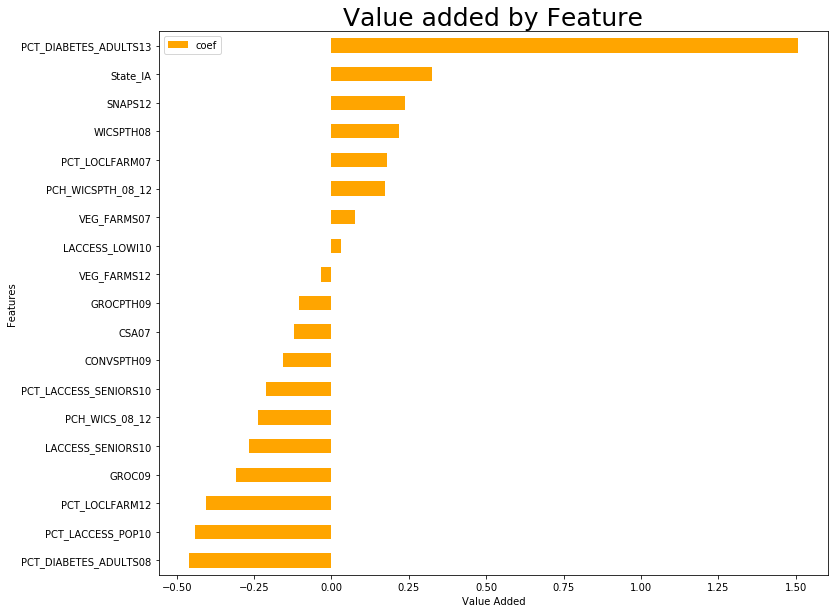

In [62]:
ax = top_bottom.sort_values(by = 'coef', ascending = False)[1:].plot(kind = 'barh', figsize = (12,10), color='orange')
ax.set(xlabel='Value Added', ylabel='Features') 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

The top features with the largest coefficient and value added to obesity rate is percent of acces to local farm, number of wics affiliated stores per population of 1,000, number of convenience stores per population of 1,000. number of grocery stores per population of 1,000 people, number of SNAP-affiliated store, percent of people that have no vehicle and a low access to store. 

## Linear Regression with correlated features 

The obesity rate per state varies from 11 to 47 so we would use linear regression instead of logistic regression since it's not bounded between zero and one

In [63]:
# features will be what is correlated to sales price after the feature engineering
correlation = df.corr()[['PCT_OBESE_ADULTS13']]
    
sorted_coefs = abs(correlation).sort_values('PCT_OBESE_ADULTS13', ascending = False)
    
strong_corr = sorted_coefs[(sorted_coefs['PCT_OBESE_ADULTS13'] > .1)]

In [64]:
#correlated features 
strong_corr.drop(['PCT_OBESE_ADULTS13'], axis=1, inplace=True)

/Users/grace1916/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
strong_corr_2 = strong_corr.drop(['PCT_OBESE_ADULTS13'])
features = list(strong_corr_2.index)

In [66]:
X_corr= df[features]
y_corr= df['PCT_OBESE_ADULTS13']

In [67]:
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, y_corr, 
                             
                                                    random_state=42)

In [68]:
lr = LinearRegression()
lr.fit(X_train_corr, y_train_corr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
lr.score(X_train_corr, y_train_corr)

0.7482809072773318

In [70]:
lr.coef_

array([ 6.80939424e-01,  5.79326744e-01, -3.24765496e-01,  1.11788824e-02,
        1.58079202e-01, -1.93567986e+00, -7.49472234e-02, -1.68709494e-02,
        4.33345369e-02,  1.79036793e-02,  1.23556497e-05, -2.78582453e-05,
        8.08201864e-05,  1.79839905e-02,  2.47573925e-02, -2.86247146e+00,
       -1.60180209e-01, -8.87700766e-03,  2.59818894e-03, -6.39280901e-02,
       -5.34331071e-03, -2.18785036e-02, -2.63492007e-01,  1.97039795e-03,
        1.61891321e-04, -3.08942304e-01,  1.20186299e-05,  1.87271009e+00,
       -1.11686378e-03,  1.87292045e+00, -1.20468278e-02,  5.30531242e-03,
       -1.41416765e+00, -2.74922401e+00,  3.03073747e-05,  3.74268336e-02,
       -3.43665566e-02, -1.97671317e-03,  1.60634344e+00, -2.73365378e-02,
        6.87088661e-01, -3.04317384e-01, -7.06906029e-01,  1.68124254e-01,
       -1.78610392e+00, -5.77729504e-01,  1.53211645e-01])

In [71]:
lr.score(X_test_corr, y_test_corr)

0.7307279743788966

In [72]:
model_1 = lr.predict(X_train_corr)

In [73]:
model_2 = lr.predict(X_test_corr)

In [74]:
regression_metrics(y_train_corr,model_1)

This is MSE: 5.071338416324772
This is RMSE: 2.2519632360064787


In [75]:
regression_metrics(y_test_corr,model_2)

This is MSE: 5.51907546759965
This is RMSE: 2.349271263094079


In [76]:
lr.coef_

array([ 6.80939424e-01,  5.79326744e-01, -3.24765496e-01,  1.11788824e-02,
        1.58079202e-01, -1.93567986e+00, -7.49472234e-02, -1.68709494e-02,
        4.33345369e-02,  1.79036793e-02,  1.23556497e-05, -2.78582453e-05,
        8.08201864e-05,  1.79839905e-02,  2.47573925e-02, -2.86247146e+00,
       -1.60180209e-01, -8.87700766e-03,  2.59818894e-03, -6.39280901e-02,
       -5.34331071e-03, -2.18785036e-02, -2.63492007e-01,  1.97039795e-03,
        1.61891321e-04, -3.08942304e-01,  1.20186299e-05,  1.87271009e+00,
       -1.11686378e-03,  1.87292045e+00, -1.20468278e-02,  5.30531242e-03,
       -1.41416765e+00, -2.74922401e+00,  3.03073747e-05,  3.74268336e-02,
       -3.43665566e-02, -1.97671317e-03,  1.60634344e+00, -2.73365378e-02,
        6.87088661e-01, -3.04317384e-01, -7.06906029e-01,  1.68124254e-01,
       -1.78610392e+00, -5.77729504e-01,  1.53211645e-01])

It is slightly better than the baseline.

In [77]:
lr_df_coef = pd.DataFrame({
    'column':features,
    'coef': lr.coef_
})

In [78]:
lr_df_coef.set_index('column', inplace=True)

In [79]:
top = lr_df_coef.head(10)
bottom = lr_df_coef.tail(10)

In [80]:
top_bottom = pd.concat([top, bottom], axis=0)

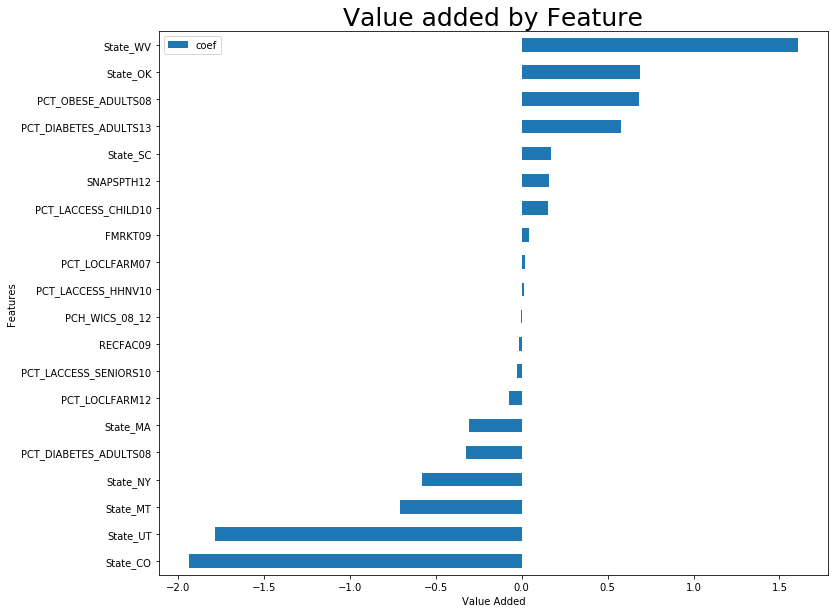

In [81]:
ax = top_bottom.sort_values(by = 'coef', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Value Added', ylabel='Features') 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

The percent of people with low access to stores and no vehicle had a impact on the obesity rate in the state. SNAP affiliated stores was again a top feature to predicting obesity rates.Colorado has the lowest obesity rate among all fifty states. The state of colorado's coefficent is -1.9. This is due to low levels in every demographic category, including age and ethnicity, and a high level of daily physical activity among children and teens.

## Regularized Linear Regression

#### Grid Search for lasso and ridge

In [82]:
def grid_search(model):
    alphas = [1.0,0.1,0.01,0.001,.00001]
    model = LassoCV(alphas ,cv=5)
    model.fit(Z_train_rf, y_train_rf)
    print(model.score(Z_train_rf, y_train_rf))
    print(model.score(Z_test_rf, y_test_rf))

#### Lasso

Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. In a Lasso model, the coefficients goes to zero and therefore easier to eliminate some of your input variable as not contributing to the output.

In [83]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV

In [84]:
lasso_alphas = [1.0,0.1,0.01,0.001,.00001]

lasso = LassoCV(alphas=lasso_alphas,
               cv=5, max_iter=5000)

# Cross-validate over our list of Lasso alphas.
lasso.fit(Z_train_rf, y_train_rf)

LassoCV(alphas=[1.0, 0.1, 0.01, 0.001, 1e-05], copy_X=True, cv=5, eps=0.001,
        fit_intercept=True, max_iter=5000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [85]:
lasso.score(Z_train_rf, y_train_rf)

0.7298535972307483

In [86]:
lasso.score(Z_test_rf, y_test_rf)

0.7220415892120288

In [87]:
pred_train_lasso = lasso.predict(Z_train_rf)
pred_test_lasso = lasso.predict(Z_test_rf)

In [88]:
regression_metrics(y_train_rf,pred_train_lasso)

This is MSE: 5.442590053767012
This is RMSE: 2.332935930060449


In [89]:
regression_metrics(y_test_rf,pred_test_lasso)

This is MSE: 5.697114070629434
This is RMSE: 2.386862809343979


In [90]:
lasso_df_coeff = pd.DataFrame({
    'column':features_RF,
    'abs_coef': np.abs(lasso.coef_)
})

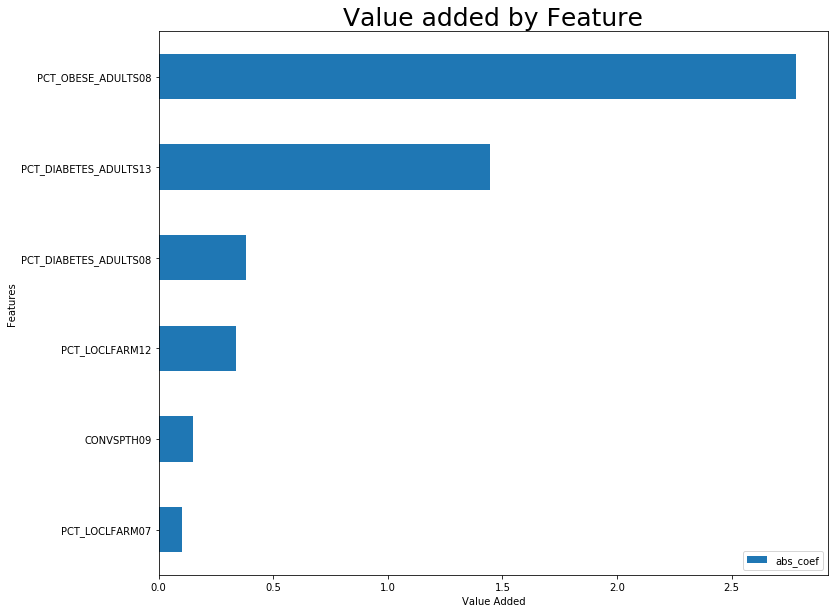

In [91]:
ax = lasso_df_coeff.set_index('column').head(6).sort_values(by = 'abs_coef', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Value Added', ylabel='Features') 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

Lasso had the best score with train of .78 and .746. The model did not suffer from overfitting. The top five features were obese adults, percent of adults with diabetes, percent of local farms, convenience stores and stores affiliates with SNAP. 

#### Ridge

Ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity. The model with ridge still suffered from being overfit. 

In [92]:
ridge_alphas = [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = ridge_alphas, scoring = 'r2', cv=5)


# Fit model using best ridge alpha!
ridge_cv.fit(Z_train_rf, y_train_rf)

RidgeCV(alphas=array([2.5e+01, 1.0e+01, 4.0e+00, 2.0e+00, 1.0e+00, 8.0e-01, 5.0e-01,
       3.0e-01, 2.0e-01, 1.0e-01, 5.0e-02, 2.0e-02, 1.0e-02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [93]:
ridge_cv.score(Z_train_rf, y_train_rf)

0.7303139005984202

In [94]:
ridge_cv.score(Z_test_rf, y_test_rf)

0.7211415450146428

In [95]:
predict_train = ridge_cv.predict(Z_train_rf)
predict_test = ridge_cv.predict(Z_test_rf)

In [96]:
regression_metrics(y_train_rf,predict_train)

This is MSE: 5.433316406200635
This is RMSE: 2.33094753398712


In [97]:
regression_metrics(y_test_rf,predict_test)

This is MSE: 5.715561630631594
This is RMSE: 2.3907240808239654


### Random Forest

The benefits of a Random Forest are that it can handle a lot of input variables without variable deletion and it gives estimates of what variables that are important in predicting the target. 

In [98]:
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor(max_depth=6,
                              random_state=42,
                              n_estimators=75)

param_grid = {
              "min_samples_leaf": [1, 2, 3, 5, 10]
             }
grid_cv = GridSearchCV(rf_reg, param_grid, cv=5, return_train_score=True)
grid_cv.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=6, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=75, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 2, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=Tr

In [99]:
grid_cv.score(Z_train_rf, y_train_rf)

0.7836621302353681

In [100]:
grid_cv.score(Z_test_rf, y_test_rf)

0.7029331713113807

In [101]:
pred_train_rf = grid_cv.predict(Z_train_rf)

In [102]:
pred_test_rf = grid_cv.predict(Z_test_rf)

In [103]:
regression_metrics(y_train_rf,pred_train_rf)

This is MSE: 4.358519403420854
This is RMSE: 2.0877067330975523


In [104]:
regression_metrics(y_test_rf,pred_test_rf)

This is MSE: 6.088765599290284
This is RMSE: 2.467542420970769


This suffers slight overfitting so we tuned the parameters, we increased the n_estimators and changed the max_depth. 

### Adaboost on Random Forest

Boosting is a general method for improving the accuracy of any given learning algorithm. Boosting aims to combine “weak” classifiers to obtain one
“strong” classifier

In [105]:
regr = AdaBoostRegressor(random_state=42, n_estimators=100)
regr.fit(Z_train_rf, y_train_rf)
AdaBoostRegressor(n_estimators=100, random_state=42)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=42)

In [106]:
regr.feature_importances_ 

array([0.42306981, 0.24500253, 0.03865761, 0.05736395, 0.0052416 ,
       0.02163814, 0.01411631, 0.00975722, 0.00274564, 0.01083999,
       0.01536285, 0.01575585, 0.02578645, 0.0025871 , 0.01433481,
       0.00137495, 0.00422888, 0.01880569, 0.00132682, 0.01664899,
       0.01823147, 0.01302636, 0.00557555, 0.01491573, 0.00360571])

In [107]:
#turning the features and score into a dataframe to then plot 
features_ada_df = pd.DataFrame({'Features': features_RF, 'Score': regr.feature_importances_.round(4)})
features_ada_df.sort_values('Score', inplace=True, ascending=False)

#just looking at the top 25 
top_25_rf = features_ada_df['Features'].head(25)

features_ada_df[3:15]

,Features,Score
2,PCT_DIABETES_ADULTS08,0.0387
12,SUPERCPTH09,0.0258
5,PCT_LOCLFARM07,0.0216
17,PCT_LACCESS_POP10,0.0188
20,GROC09,0.0182
19,SNAPS12,0.0166
11,LACCESS_HHNV10,0.0158
10,WICSPTH12,0.0154
23,LACCESS_LOWI10,0.0149
14,PCT_LACCESS_CHILD10,0.0143


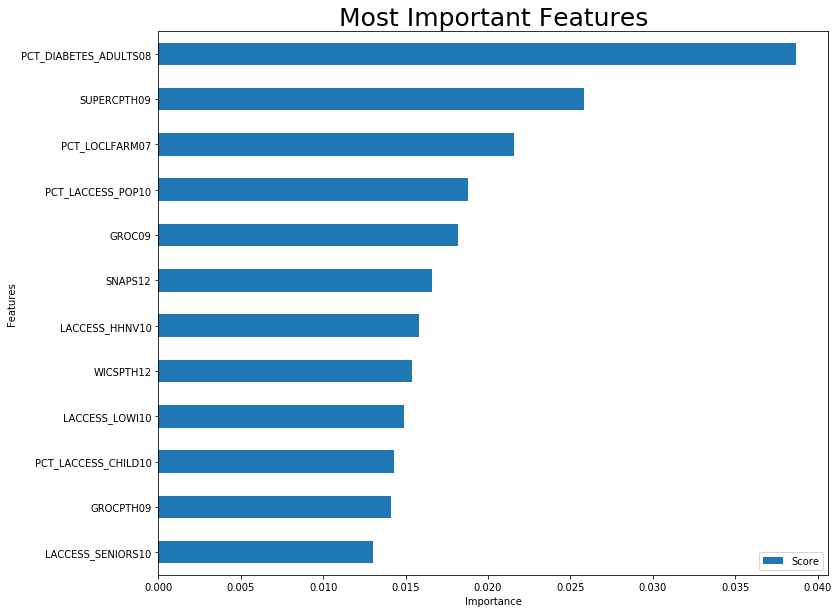

In [108]:
ax = features_ada_df.set_index('Features')[3:15].sort_values(by = 'Score', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Importance', ylabel='Features') 
ax.invert_yaxis()
plt.title('Most Important Features', fontsize = 25);

In [109]:
adaboost_pred_train = regr.predict(Z_train_rf)
adaboost_pred_test = regr.predict(Z_test_rf)

In [110]:
regression_metrics(y_train_rf,adaboost_pred_train)

This is MSE: 5.898724515314373
This is RMSE: 2.4287289917391717


In [111]:
regression_metrics(y_test_rf,adaboost_pred_test)

This is MSE: 7.1948072648433214
This is RMSE: 2.682313789407071


In [112]:
regr.score(Z_train_rf, y_train_rf)

0.7072130744743408

In [113]:
regr.score(Z_test_rf, y_test_rf)

0.6489701332168254

The training and testing score was lower than the random forest and linear regression models. 

### Decision Tree Regressor

In [114]:
from sklearn.tree import DecisionTreeRegressor

In [115]:
model =  DecisionTreeRegressor(max_depth=4,random_state=42)
model.fit(Z_train_rf, y_train_rf)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [116]:
model.score(Z_train_rf, y_train_rf)

0.7011268230114283

In [117]:
model.score(Z_test_rf, y_test_rf)

0.657067483341438

## Predictions

In [118]:
import statsmodels.api as sm
X = df[features_RF] 
y = df ['PCT_OBESE_ADULTS13']


X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/grace1916/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PCT_OBESE_ADULTS13   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     317.1
Date:                Tue, 10 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:26:34   Log-Likelihood:                -6749.1
No. Observations:                2973   AIC:                         1.355e+04
Df Residuals:                    2947   BIC:                         1.371e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.0124      0.444     11.289      0.000       4.142       5.883
PCT_OBESE_ADULTS08        0.7518      0.019     38.577      0.000       0.714       0.790
PCT_DIABETES_ADULTS13     0.5866      0.036     16.147      0.000       0.515       0.658
PCT_DIABETES_ADULTS08    -0.1938      0.046     -4.172      0.000      -0.285      -0.103
PCT_LOCLFARM12           -0.0470      0.012     -3.797      0.000      -0.071      -0.023
CONVSPTH09               -0.4828      0.182     -2.660      0.008      -0.839      -0.127
PCT_LOCLFARM07            0.0087      0.014      0.638      0.524      -0.018       0.035
GROCPTH09                -0.7018      0.346     -2.031      0.042      -1.379      -0.024
WICSPTH08                 0.4967      0.602      0.825      0.409      -0.684       1.677
PCH_WICSPTH_08_12         0.0060      0.010      0.602      0.547      -0.014       0.026
PCT_LACCESS_SENIORS10    -0.0479      0.039     -1.225      0.221      -0.124       0.029
WICSPTH12                 0.7790      0.720      1.081      0.280      -0.634       2.192
LACCESS_HHNV10            0.0001      0.000      1.008      0.314   -9.73e-05       0.000
SUPERCPTH09               7.5329      2.233      3.373      0.001       3.154      11.912
SPECSPTH09                0.8854      0.634      1.397      0.162      -0.357       2.128
PCT_LACCESS_CHILD10       0.1100      0.044      2.506      0.012       0.024       0.196
VEG_FARMS12               0.0008      0.003      0.266      0.790      -0.005       0.007
VEG_FARMS07               0.0009      0.003      0.337      0.736      -0.004       0.006
PCT_LACCESS_POP10        -0.0199      0.015     -1.283      0.200      -0.050       0.010
State_IA                  2.0200      0.251      8.039      0.000       1.527       2.513
SNAPS12                   0.0015      0.001      1.833      0.067      -0.000       0.003
GROC09                   -0.0049      0.002     -2.401      0.016      -0.009      -0.001
LACCESS_SENIORS10      -4.02e-05   1.56e-05     -2.573      0.010   -7.08e-05   -9.56e-06
CSA07                    -0.0240      0.010     -2.329      0.020      -0.044      -0.004
LACCESS_LOWI10        -2.718e-06   7.86e-06     -0.346      0.730   -1.81e-05    1.27e-05
PCH_WICS_08_12           -0.0090      0.010     -0.916      0.360      -0.028       0.010
==============================================================================
Omnibus:                       11.168   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.495
Skew:                           0.125   Prob(JB):                      0.00319
Kurtosis:                       3.175   Cond. No.                     8.63e+05
==============================================================================

The number of grocery stores per population of 1000, the number of convenience store, percent with low access to food stores,the percent of those without a car, the percent of local produce, the availability of vegetable farms, the percent of speciality store all had significant impact on obesity rates.  

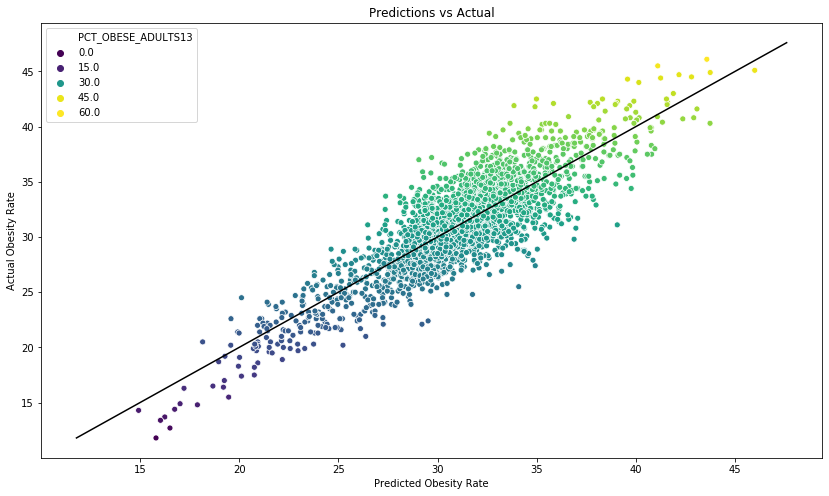

In [119]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(pred_train_lasso, y_train_rf, hue=y_train_rf, palette='viridis', legend="brief");
ax.plot([np.min(y), np.max(y)],
         [np.min(y), np.max(y)],
         color = 'black')
ax.set(xlabel="Predicted Obesity Rate", ylabel="Actual Obesity Rate", title="Predictions vs Actual");

### Table of results


|Model                                         | RMSE Train      | RMSE Test      | R2 Train          |  R2 Test  
|-------------------------------------------   |-----------------|----------------|-------------------|----------
| Baseline                                     |      4.48       |      4.46      |       --          |       --
| Linear Regression with all features          |      1.22       |      2.34      |   .92             |      .62
| Linear Regression with Random Forest features|      1.22       |      2.34      |   .92             |      .62
  Linear Regression with correlated features   |      2.25       |      2.34      |   .72             |      .73
| Lasso                                        |      2.33       |      2.32      |   .77             |      .75
| Ridge                                        |      2.33       |      2.39      |   .77             |      .75
| Random Forest                                |      2.07       |      2.4       |   .79             |      .70  | Adaboost                                     |      2.70       |      2.45      |   .70             |      .65

# Conclusions and Limitations

The top features with the largest coefficient and value added to obesity rate among all the models are percent of acces to local farm, number of wics affiliated stores per population of 1,000, number of convenience stores per population of 1,000, number of grocery stores per population of 1,000 people, number of SNAP-affiliated store, percent of people that have no vehicle and a low access to store. This analysis showed how access to different types of food stores could impact obesity rates among adults and found that there is a relationship between the access to food stores and obesity among adults. Food insecurity has been associated with low food expenditure, low fruit and vegetable consumption, and a less-healthy diet. Throughout our analysis, areas with low access to healthy food options tend to have higher adult obesity and diabetes rates. 


However, the model scores did not represent a strong evidence that these factors were the only variables affecting obesity. In the U.S., healthier food items tend to be a lot more expensive than the unhealthy food items. As result, even if the counties had a lot of different food options and easy access to healthier food stores, a low-income household will choose the cheapest option and ignore the health consequences. The region of the U.S. is also very important factor that accounts for the obesity levels. Some counties had a small number of grocery stores and access to healthy food options, and many households do not have access to a car. The lack of access to supermarkets has a greater chance of health challenges such as diabetes, heart disease and cancer. Unhealthy food may be a lot cheaper in the short run but there is significant evidence that unhealthy eating will lead to diabetes, cardiovascular disease and other life threatening diseases. The consequences in the long run are a lot worse.In order to end obesity in the U.S., we need to make the healthier food options more affordable. If we were to conduct this study again, we would want to look at prices of the food items and make interaction terms with the price variables and the stores variables. Prices have a lot of impact on what Americans choose to eat. Therefore, the regression with food prices might have a higher score and show a stronger relationship to the obesity rate in adults.

## Sources

Walker, Renee E., Jason Block, and Ichiro Kawachi. "Do Residents of Food Deserts Express Different Food Buying Preferences Compared to Residents of Food Oases? A Mixed-methods Analysis." N.p., 10 Apr. 2012. Web.

Ghosh-Dastidar, B., D. Cohen, G. Hunter, S. N. Zenk, C. Huang, R. Beckman, and T. Dubowitz. "Distance to Store, Food Prices, and Obesity in Urban Food Deserts." N.p., Nov. 2014. Web.

Powell, Lisa M., Sandy Slater, Donka Mirtcheva, Yanjun Bao, and Frank J. Chaloupk. "Food Store Availability and Neighborhood Characteristics in the United States." N.p., 25 Sept. 2006. Web